# Timeseries classification with a Transformer model

copy from https://keras.io/examples/timeseries/timeseries_classification_transformer/

Example Key Word : 시계열 데이터, Transformer, 분류

Transformer 모델을 시계열 데이터에 적용한 것


Timeseries classification from scratch 와 거의 동일하고 오로지 모델만 바꾸었다.


# 데이터 준비

In [1]:
import numpy as np


def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

# 학습

## 모델 정의

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

transformer encoder 블럭 정의

In [4]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


transformer encoder 블럭을 쌓아서 전체 모델을 정의한다.

In [5]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # flatten() 대신 GloabalAveragePooling1D()를 사용하였다.
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


In [10]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

## 컴파일

In [11]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 500, 1)]     0                                            
__________________________________________________________________________________________________
layer_normalization_8 (LayerNor (None, 500, 1)       2           input_2[0][0]                    
__________________________________________________________________________________________________
multi_head_attention_4 (MultiHe (None, 500, 1)       7169        layer_normalization_8[0][0]      
                                                                 layer_normalization_8[0][0]      
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 500, 1)       0           multi_head_attention_4[0][0

## 학습 실행

In [12]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=128,
    callbacks=callbacks,
)

Epoch 1/200
23/23 [==============================] - 27s 1s/step - loss: 1.0886 - sparse_categorical_accuracy: 0.5184 - val_loss: 0.7760 - val_sparse_categorical_accuracy: 0.5492
Epoch 2/200
23/23 [==============================] - 25s 1s/step - loss: 0.9776 - sparse_categorical_accuracy: 0.5299 - val_loss: 0.6986 - val_sparse_categorical_accuracy: 0.5964
Epoch 3/200
23/23 [==============================] - 24s 1s/step - loss: 0.8754 - sparse_categorical_accuracy: 0.5736 - val_loss: 0.6517 - val_sparse_categorical_accuracy: 0.6283
Epoch 4/200
23/23 [==============================] - 23s 1s/step - loss: 0.8189 - sparse_categorical_accuracy: 0.5816 - val_loss: 0.6229 - val_sparse_categorical_accuracy: 0.6560
Epoch 5/200
23/23 [==============================] - 24s 1s/step - loss: 0.7812 - sparse_categorical_accuracy: 0.6083 - val_loss: 0.5996 - val_sparse_categorical_accuracy: 0.6852
Epoch 6/200
23/23 [==============================] - 24s 1s/step - loss: 0.7499 - sparse_categorical_accu

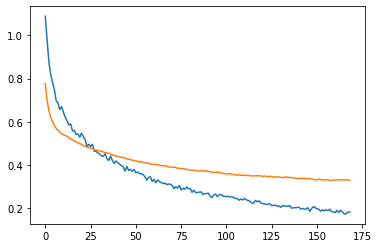

In [14]:
import matplotlib.pyplot as plt

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.show()

# 평가

In [15]:
model.evaluate(x_test, y_test, verbose=1)

42/42 [==============================] - 3s 80ms/step - loss: 0.3337 - sparse_categorical_accuracy: 0.8424


[0.33368781208992004, 0.842424213886261]